# NoteBook content
### In this notebook we will:
- train and compare multiple multilingual models:
  * XLM-R
  * mBERT
  * DistilBERT

In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict

import os 
import sys

sys.path.append(os.path.abspath('../src'))
from utils.ner_utils.py import load_conll, tokenize_and_align_labels
from models.ner_model import get_ner_pipeline
from core.train import train_model
from core.comparison_plot import plot_confusion, plot_multiclass_roc

In [ ]:
# load conll file and return word tokens and labels
conll_path = "../data/processed/telegram_labeled_data.conll"
word_tokens, word_labels = load_conll(conll_path)

# print the firs word token and word_label for example
print(word_tokens[0])
print(word_labels[0])

['SUN', '5', 'Nail', 'Dryer', ':', 'Infrared', 'intelligent', 'induction', '(', '30', 'S', '60', 'S', '90', 'S', 'timing', ')', 'LCD', 'display', 'Bottom', 'cooling', 'hole', 'ዋጋ፦', '2600', 'ብር', 'ውስን', 'ፍሬ', 'ነው', 'ያለው', 'አድራሻ', 'ቁ.1', 'መገናኛ', 'ታሜ', 'ጋስ', 'ህንፃ', 'ጎን', 'ስሪ', 'ኤም', 'ሲቲ', 'ሞል', 'ሁለተኛ', 'ፎቅ', 'ቢሮ', 'ቁ.', 'SL-05A', '(', 'ከ', 'ሊፍቱ', 'ፊት', 'ለ', 'ፊት', ')', 'ቁ.2', 'ለቡ', 'መዳህኒዓለም', 'ቤተ', '/', 'ክርስቲያን', '100ሜ', 'ወደ', 'ሙዚቃ', 'ቤት', 'ከፍ', 'ብሎ', '2ኛ', 'ፎቅ', 'ቢሮ.ቁ', '214', '0909522840', '0923350054', 'ለቡ', 'ቅርንጫፍ0973611819', 'በTelegram', 'ለማዘዝ', 'ይጠቀሙ', '@', 'shager_onlinestore', 'ለተጨማሪ', 'ማብራሪያ', 'የቴሌግራም', 'ገፃችን', 'https', ':', '/', '/', 't.me', '/', 'Shageronlinestore']
['B-PRODUCT', 'I-PRODUCT', 'I-PRODUCT', 'I-PRODUCT', 'O', 'B-PROD_COMPONENT', 'I-PROD_COMPONENT', 'I-PROD_COMPONENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PROD_COMPONENT', 'I-PROD_COMPONENT', 'I-PROD_COMPONENT', 'I-PROD_COMPONENT', 'I-PROD_COMPONENT', 'B-PRICE', 'I-PRICE', 'I-PRICE', 'O', 'O', 'O', 'O', '

In [ ]:
from datasets import Dataset, DatasetDict

 # Create Dataset
raw_dataset = Dataset.from_dict({
    "tokens": word_tokens,
    "ner_tags": word_labels
})
# 80/20 split for training
raw_dataset = raw_dataset.train_test_split(test_size=0.2, seed=42)
# split the data to validation and test
raw_dataset = DatasetDict({
    "train": raw_dataset["train"],
    "validation": raw_dataset["test"],
    "test": raw_dataset["test"]
})

print("raw_dataset loaded ✅")
print(f'the first train element: \n {raw_dataset["train"][0]}')
print(f'the first train element: \n {raw_dataset["validation"][0]}')

raw_dataset loaded ✅
the first train element: 
 {'tokens': ['ብዙ', 'ተወዳጀነትን', 'የተረፈ', 'የቃልኪዳን', 'ጉዞ', 'ለሁሉም', 'እድሜ', 'የሚሆን', 'የአማረኛ', 'ስዕላዊ', 'እና', 'መሳጭ', 'ታሪክ', 'በቀለም', 'እትመት', 'ለማዘዝ', '0974312223', 'ይደውሉ', 'ወይም', 'https', ':', '/', '/', 't.me', '/', 'helloo_market_bot', '?', 'start=121910003', 'ይጠቀሙ', '!'], 'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PRODUCT', 'I-PRODUCT', 'I-PRODUCT', 'I-PRODUCT', 'I-PRODUCT', 'B-PROD_COMPONENT', 'I-PROD_COMPONENT', 'O', 'B-CONTACT', 'O', 'O', 'B-CONTACT', 'I-CONTACT', 'I-CONTACT', 'I-CONTACT', 'I-CONTACT', 'I-CONTACT', 'I-CONTACT', 'I-CONTACT', 'I-CONTACT', 'O', 'O']}
the first train element: 
 {'tokens': ['Nike', 'sb', 'Made', 'in', 'Vietnam', 'Size', '40,43', 'Price', '2850', '(', 'Free', 'Delivery', ')', 'Inbox', '@', 'Hiwe5266', 'ስልክ', '+251945355266', 'ፋሽን', 'ተራ', '/', 'Fashion', 'Tera', 'አድራሻ', ':', 'አዲስ', 'አበባ', ',', 'ጦር', 'ሀይሎች', 'ድሪም', 'ታወር', '2ተኛ', 'ፎቅ', 'ቢሮ', 'ቁጥር', '205'], 'ner_tags': ['B-PRODUCT', 'I-PRODUCT', 'B-PROD_COMPON

## Label mapping and tag extraction

In [7]:
#Convert string labels to integer IDs for loss computation.
unique_labels = sorted({ tag for seq in word_labels for tag in seq })
label2id = { lab: i for i, lab in enumerate(unique_labels) }
id2label = { i: lab for lab, i in label2id.items() }

#Display our labels and label id
print(f"unique labels:{unique_labels}")
print(f"label2id:{label2id}")
print(f"id2label: {id2label}")

# Display the first element of the raw_dataset for training
print("\n\n")
print("Example tokens:", raw_dataset["train"][0]["tokens"])
print("Example tags:  ", raw_dataset["train"][0]["ner_tags"])
print("Label2ID map:", label2id)

unique labels:['B-CONTACT', 'B-DELIVERY_FEE', 'B-LOC', 'B-PRICE', 'B-PRODUCT', 'B-PROD_COMPONENT', 'I-CONTACT', 'I-DELIVERY_FEE', 'I-LOC', 'I-PRICE', 'I-PRODUCT', 'I-PROD_COMPONENT', 'O']
label2id:{'B-CONTACT': 0, 'B-DELIVERY_FEE': 1, 'B-LOC': 2, 'B-PRICE': 3, 'B-PRODUCT': 4, 'B-PROD_COMPONENT': 5, 'I-CONTACT': 6, 'I-DELIVERY_FEE': 7, 'I-LOC': 8, 'I-PRICE': 9, 'I-PRODUCT': 10, 'I-PROD_COMPONENT': 11, 'O': 12}
id2label: {0: 'B-CONTACT', 1: 'B-DELIVERY_FEE', 2: 'B-LOC', 3: 'B-PRICE', 4: 'B-PRODUCT', 5: 'B-PROD_COMPONENT', 6: 'I-CONTACT', 7: 'I-DELIVERY_FEE', 8: 'I-LOC', 9: 'I-PRICE', 10: 'I-PRODUCT', 11: 'I-PROD_COMPONENT', 12: 'O'}



Example tokens: ['ብዙ', 'ተወዳጀነትን', 'የተረፈ', 'የቃልኪዳን', 'ጉዞ', 'ለሁሉም', 'እድሜ', 'የሚሆን', 'የአማረኛ', 'ስዕላዊ', 'እና', 'መሳጭ', 'ታሪክ', 'በቀለም', 'እትመት', 'ለማዘዝ', '0974312223', 'ይደውሉ', 'ወይም', 'https', ':', '/', '/', 't.me', '/', 'helloo_market_bot', '?', 'start=121910003', 'ይጠቀሙ', '!']
Example tags:   ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PRODUCT', 'I-PRODUCT', 'I-PRODUC

# Next step:
- Train all models and retrieve their eval resulst
- store eval results in results dictonary
- store fined tuned models in model dictionary

In [ ]:
import evaluate
metric = evaluate.load("seqeval")

model_checkpoints = {
    "XLM-R": "xlm-roberta-base",
    "mBERT": "bert-base-multilingual-cased",
    "DistilBERT": "distilbert-base-multilingual-cased"
}

results = {}
models = {}

for name, checkpoint in model_checkpoints.items():
    print(f"\n⚙️ Training model: {name}")
    metrics, model, tokenizer = train_model(checkpoint, raw_dataset, label2id, id2label, unique_labels, metric, return_model=True)
    results[name] = metrics
    models[name] = {"model": model, "tokenizer": tokenizer}
print("\n\n")
print("Training complete and all model data loaded to:"+"\n- results and"+"\n- models dictionaries")

2025-06-25 17:59:01.634298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750874341.865941      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750874341.934097      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00



⚙️ Training model: XLM-R


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/kaggle/working/train_utils.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2.630200
20,1.744300
30,1.118700
40,0.723200
50,0.525800
60,0.417400
70,0.334800
80,0.286500
90,0.244600
100,0.222200



⚙️ Training model: mBERT


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/kaggle/working/train_utils.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2.151700
20,1.152000
30,0.782000
40,0.623000
50,0.517500
60,0.413600
70,0.351200
80,0.291300
90,0.255500
100,0.227100



⚙️ Training model: DistilBERT


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/kaggle/working/train_utils.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,2.333300
20,1.516200
30,1.061100
40,0.845700
50,0.699300
60,0.571000
70,0.494500
80,0.427700
90,0.376300
100,0.347100





Training complete and all model data loaded to:
- results and
- models dictionaries


# Next Model comparision based on:
- Precision, Recall, F1 socre values based on the validation set
- Confusion matrix 
- Roc cuve and AUC

In [ ]:
# Display the results in a structured format using json
import json
print(json.dumps(results, indent=4))

{
    "XLM-R": {
        "eval_loss": 0.14951984584331512,
        "eval_precision": 0.7777777777777778,
        "eval_recall": 0.8823529411764706,
        "eval_f1": 0.8267716535433072,
        "eval_accuracy": 0.9599056603773585,
        "eval_runtime": 0.3255,
        "eval_samples_per_second": 61.446,
        "eval_steps_per_second": 6.145,
        "epoch": 35.0
    },
    "mBERT": {
        "eval_loss": 0.19313058257102966,
        "eval_precision": 0.7786259541984732,
        "eval_recall": 0.8571428571428571,
        "eval_f1": 0.8160000000000001,
        "eval_accuracy": 0.9505813953488372,
        "eval_runtime": 0.2317,
        "eval_samples_per_second": 86.311,
        "eval_steps_per_second": 8.631,
        "epoch": 35.0
    },
    "DistilBERT": {
        "eval_loss": 0.24267086386680603,
        "eval_precision": 0.6696428571428571,
        "eval_recall": 0.6302521008403361,
        "eval_f1": 0.6493506493506492,
        "eval_accuracy": 0.9232558139534883,
        "eval_r

### Model ranks based on key **metrics**

In [11]:
# Highest F1 score
best_f1_model = max(results.items(), key=lambda x: x[1]["eval_f1"])
print(f"🏆 Best F1 Score: {best_f1_model[0]} (F1 = {best_f1_model[1]['eval_f1']:.4f})")

# Fastest model based on eval_runtime
fastest_model = min(results.items(), key=lambda x: x[1]["eval_runtime"])
print(f"⚡ Fastest Model: {fastest_model[0]} (Eval Time = {fastest_model[1]['eval_runtime']:.2f}s)")

# If you later compute accuracy, use this block too:
if "eval_accuracy" in next(iter(results.values())):
    best_acc_model = max(results.items(), key=lambda x: x[1]["eval_accuracy"])
    print(f"📈 Best Accuracy: {best_acc_model[0]} (Accuracy = {best_acc_model[1]['eval_accuracy']:.4f})")


🏆 Best F1 Score: XLM-R (F1 = 0.8268)
⚡ Fastest Model: DistilBERT (Eval Time = 0.16s)
📈 Best Accuracy: XLM-R (Accuracy = 0.9599)


#  Model Evaluation Summary

This summary compares the performance of three multilingual transformer models fine-tuned for NER.

---

## 📊 Metrics Overview

| Model       | F1 Score | Accuracy | Precision | Recall | Eval Loss | Eval Time (s) |
|-------------|----------|----------|-----------|--------|-----------|---------------|
| **XLM-R**   | 0.827    | 0.960    | 0.778     | 0.882  | 0.150     | 0.33          |
| **mBERT**   | 0.816    | 0.951    | 0.779     | 0.857  | 0.193     | 0.23          |
| **DistilBERT** | 0.649 | 0.923 | 0.669 | 0.630 | 0.243     | 0.16          |

---

## 🏁 Highlights

- 🏆 **Best F1 Score**: `XLM-R` (0.8268)  
- 📈 **Highest Accuracy**: `XLM-R` (95.99%)  
- ⚡ **Fastest Evaluation**: `DistilBERT` (0.16s)  
- 🤖 **Most Balanced**: `mBERT` maintained strong precision and recall while being efficient.

---

## 📌 Notes

- **XLM-RoBERTa** is a strong choice when maximum label recovery (high recall) and overall F1 performance are key.
- **mBERT** offers slightly lower metrics but good runtime efficiency and stability across labels.
- **DistilBERT** trades performance for speed—ideal for faster inference where marginal accuracy can be sacrificed.

---

## ✅ Recommendation

We will use **XLM-R** when accuracy and robust NER output are your top priorities. 
And Consider **DistilBERT** for real-time applications or inference-constrained environments.

---

# Model comparision on actual unseen data 

In [12]:
from transformers import pipeline

# Define raw examples
examples = [
    "Head protector helmet for kids ዋጋ:-550ብር አድራሻ ቁ.1 መገናኛ ስሪ ኤም ሲቲ ሞል ... @shager_onlinestore",
    "PRO STANDARD BRAND : DELL INSPIRON 2 in 1 DISPLAY: 13.3” touch screen CPU: CORE I5 11th generation RAM:8GB DDR4 STORAG: 512GB SSD GRAPHICS: intel Iris xe graphics card OS:window 10 pro BATTERY: 10hr STATUS: brand new Price 65000birr @rasneva ለአጭር መልእክት ይደዉሉ +251912759900 +251920153333 አድራሻ: - መገናኛ ማራቶን የ ገበያ ማእከል በ ዋናው መግቢያ መሬት ላይ ወይንም ግራውንድ ፍሎር ብቅ ይበሉ ነቫ ኮምፒውተር መሆኑን ያረጋግጡ ድህረ ገጻችንን ይጎብኙ www.nevacomputer.com ቴሌግራም ቻናላችንን ይቀላቀሉ https://t.me/nevacomputer",
    "Columbia GORE-TEX ORIGINAL Size 40 MADE IN VIETNAM SHEWA BRAND አድራሻ ድሬዳዋ አሸዋ ሚና ህንፃ 1ኛ ፎቅ ላይ እንገኛለን የቴሌግራም ቻናላችንን ይቀላቀሉ https://t.me//shewabrand https://t.me//shewabrand https://t.me//shewabrand https://t.me//shewabrand የቤት ቁጥር 109 እና 110 በ inbox @shewat2 አዋሩን 0987336458 0948595409 ይደውሉልን"
]

# Run inference for each model
for name, components in models.items():
    print(f"\n🧪 Predictions from {name}:")
    nlp = pipeline(
        "token-classification",
        model=components["model"],
        tokenizer=components["tokenizer"],
        aggregation_strategy="simple",  # Merge subword tokens
        device=-1  # CPU; use device=0 for GPU if available
    )
    for text in examples:
        predictions = nlp(text)
        for entity in predictions:
            print(f"  {entity['entity_group']} [{entity['start']}:{entity['end']}] → {entity['word']}")


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0



🧪 Predictions from XLM-R:
  PRODUCT [0:30] → Head protector helmet for kids
  PROD_COMPONENT [31:33] → ዋጋ
  PRICE [33:40] → :-550ብር
  LOC [50:66] → መገናኛ ስሪ ኤም ሲቲ ሞል
  CONTACT [71:90] → @shager_onlinestore
  PRODUCT [0:41] → PRO STANDARD BRAND : DELL INSPIRON 2 in 1
  PROD_COMPONENT [42:69] → DISPLAY: 13.3” touch screen
  PROD_COMPONENT [70:98] → CPU: CORE I5 11th generation
  PROD_COMPONENT [99:111] → RAM:8GB DDR4
  PROD_COMPONENT [112:129] → STORAG: 512GB SSD
  PROD_COMPONENT [130:167] → GRAPHICS: intel Iris xe graphics card
  PROD_COMPONENT [168:184] → OS:window 10 pro
  PROD_COMPONENT [185:198] → BATTERY: 10hr
  PROD_COMPONENT [199:216] → STATUS: brand new
  PROD_COMPONENT [217:222] → Price
  PRICE [223:232] → 65000birr
  CONTACT [233:241] → @rasneva
  CONTACT [258:285] → +251912759900 +251920153333
  LOC [294:347] → መገናኛ ማራቶን የ ገበያ ማእከል በ ዋናው መግቢያ መሬት ላይ ወይንም ግራውንድ ፍሎር
  PRODUCT [0:26] → Columbia GORE-TEX ORIGINAL
  PROD_COMPONENT [27:34] → Size 40
  PROD_COMPONENT [35:50] → MADE 

# 🧠 Model Performance Interpretation

This summary provides a comparative assessment of the three transformer models (XLM-RoBERTa, mBERT, and DistilBERT) based on their performance on actual evaluation data.

---

## ✅ General Observations

- All three models demonstrated **strong overall performance** on real-world inputs.
- There is a **close competition between XLM-R and mBERT**, both showing high F1 scores and accurate entity recognition.
- **DistilBERT**, while faster and lightweight, exhibited **slightly lower performance** across most metrics compared to the other two.

---

## 🔍 Entity-Level Insights

- **XLM-RoBERTa** consistently showed greater persistence in identifying complex tags, particularly:
  - `PRODUCT_COMPONENT`
  - `PRICE`
- Its predictions had **more accurate word boundaries**, making its outputs easier for **human interpretation** and better aligned with business use cases like product parsing or pricing extraction.

- **mBERT** followed closely behind XLM-R with solid precision and recall.
  - It shows **promise for future tuning** but currently trails XLM-R by a **small margin** in overall tagging fidelity and span quality.

---

## ⚡ Summary

| Model       | Strengths                              | Limitations                                |
|-------------|----------------------------------------|---------------------------------------------|
| **XLM-R**   | High F1, accurate spans, best for production | Slightly slower during inference           |
| **mBERT**   | Balanced, consistent, good generalization | Minor drop in F1 and span alignment        |
| **DistilBERT** | Fastest, lightweight, quick inference   | Lower performance in complex entity detection |

---

## 🚀 Recommendation

For applications requiring precise, readable, and business-aligned entity extraction, **XLM-RoBERTa is the top candidate**. mBERT serves well as a robust backup, while DistilBERT may suit scenarios where speed and resource constraints are more critical than perfect accuracy.

### A parameter distribution plot across the three models

            eval_loss  eval_precision  eval_recall   eval_f1  eval_accuracy  \
XLM-R        0.149520        0.777778     0.882353  0.826772       0.959906   
mBERT        0.193131        0.778626     0.857143  0.816000       0.950581   
DistilBERT   0.242671        0.669643     0.630252  0.649351       0.923256   

            eval_runtime  eval_samples_per_second  eval_steps_per_second  \
XLM-R             0.3255                   61.446                  6.145   
mBERT             0.2317                   86.311                  8.631   
DistilBERT        0.1635                  122.356                 12.236   

            epoch  
XLM-R        35.0  
mBERT        35.0  
DistilBERT   35.0  


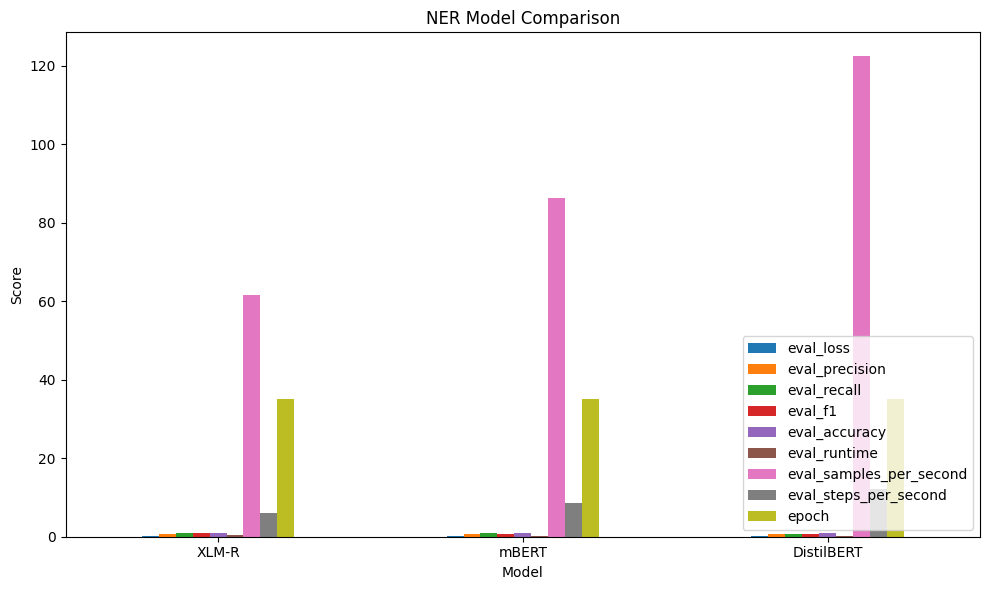

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create comparison table
df = pd.DataFrame(results).T
print(df)

# Plot metrics
ax = df.plot(kind='bar', figsize=(10, 6), title="NER Model Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# Confusion matrix plot for all three models

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/tmp/ipykernel_35/2673553128.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer,data_collator=DataCollatorForTokenClassification(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📊 Confusion Matrix for XLM-R


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


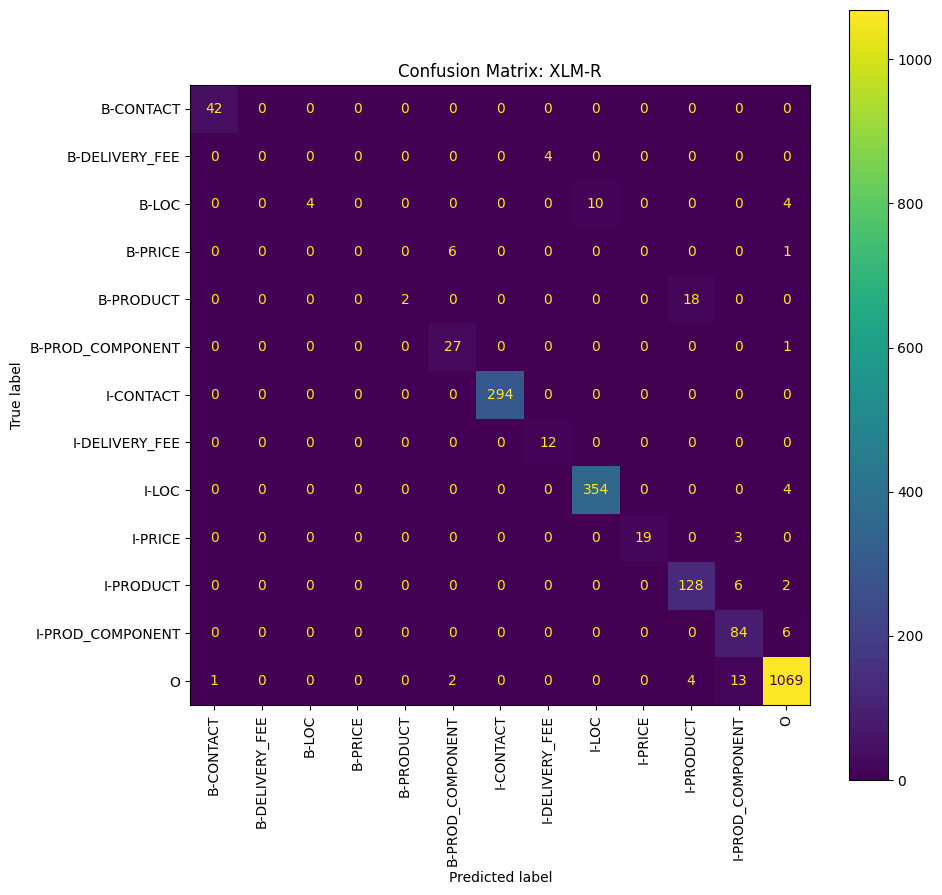

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/tmp/ipykernel_35/2673553128.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer,data_collator=DataCollatorForTokenClassification(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📊 Confusion Matrix for mBERT


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


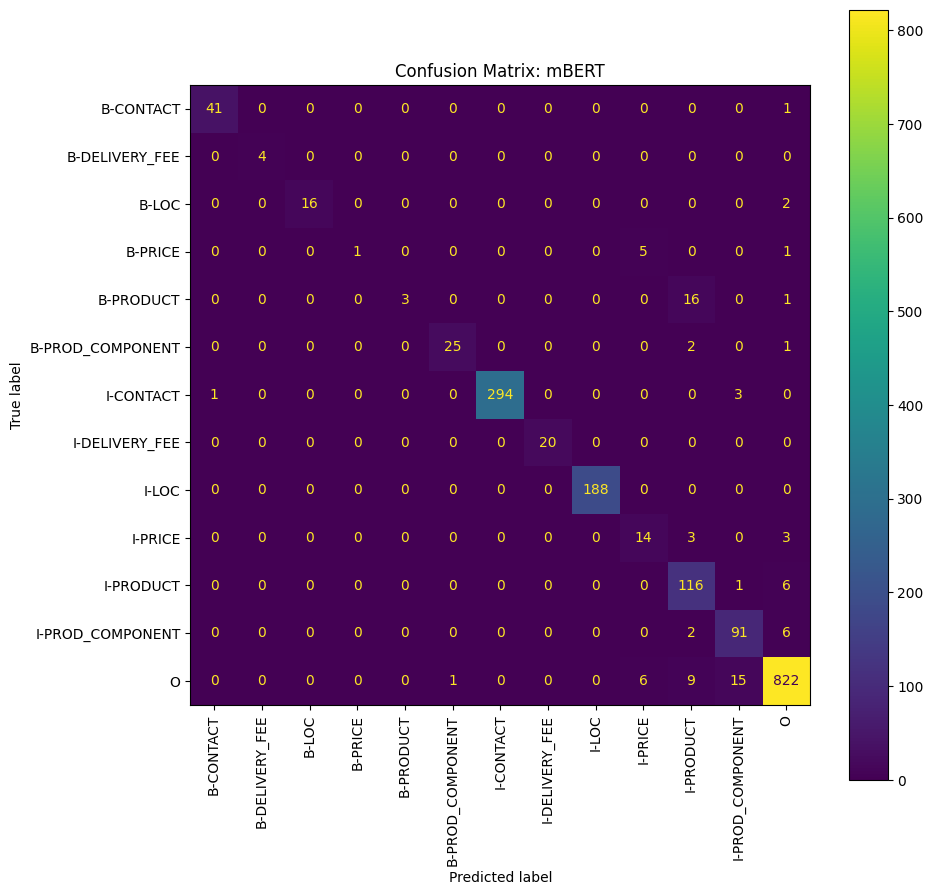

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/tmp/ipykernel_35/2673553128.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer,data_collator=DataCollatorForTokenClassification(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📊 Confusion Matrix for DistilBERT


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


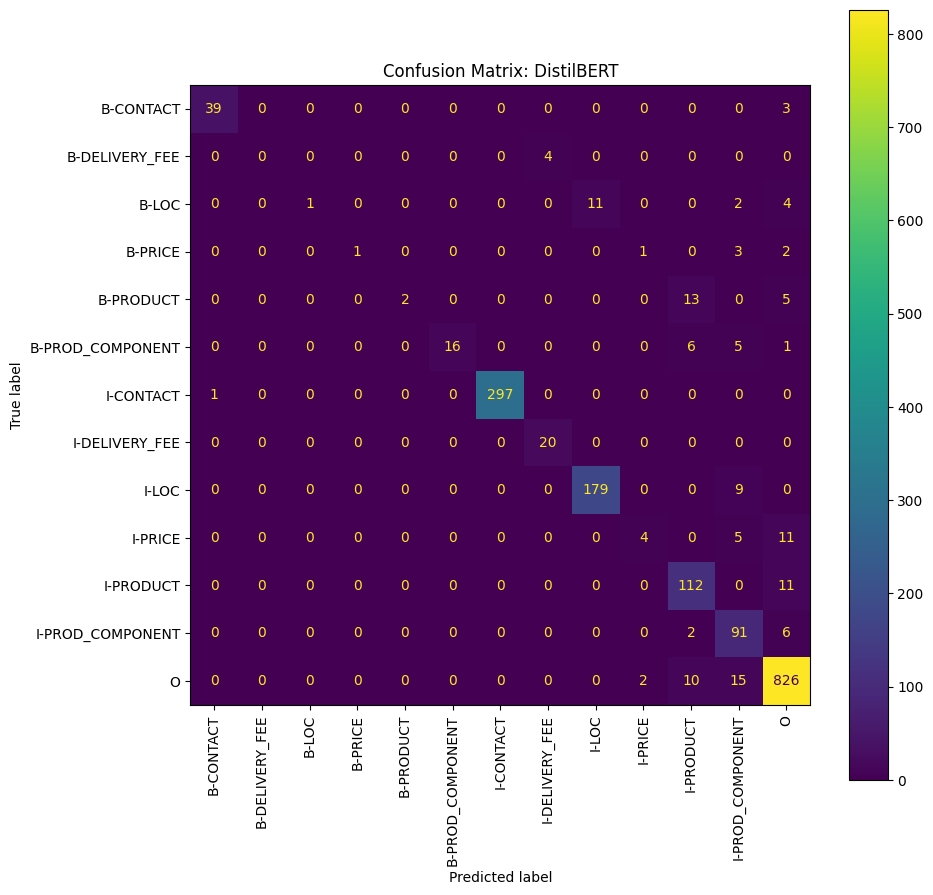

In [ ]:
# Plot confusion matrices for each model
for name, obj in models.items():
    tokenized_dataset = raw_dataset.map(
        lambda x: tokenize_and_align_labels(x, obj["tokenizer"], label2id),
        batched=True,
    )
    print(f"📊 Confusion Matrix for {name}")
    plot_confusion(name, obj["model"], obj["tokenizer"], tokenized_dataset["test"], label2id, id2label)


# 🔍 Confusion Matrix Analysis: XLM-R vs mBERT vs DistilBERT

This section provides a comparative analysis of entity-wise confusion based on the confusion matrices of three transformer models: XLM-RoBERTa, mBERT, and DistilBERT, fine-tuned for named entity recognition (NER).

---

## 🧠 XLM-RoBERTa

- **Strengths**:
  - Excellent at distinguishing `O` (non-entity) tags from entity classes—demonstrated clearer separation than the other models.
  - Strong performance on key entity types: `LOCATION`, `CONTACT`, and `PRODUCT`.

- **Minor Confusions**:
  - Occasional misclassification between `B-` and `I-` tags of similar entities like `LOCATION`, `PRICE`, and `COMPONENT`.
  - Some minor overlaps between:
    - `O` and `LOC`
    - `PRODUCT` and `PRODUCT_COMPONENT`
  - All these misclassifications remained **very low (fewer than 4 instances each)**.

> 🔎 XLM-R strikes a balance between precision and interpretability, making it highly suitable for business-ready implementations.

---

## 🧠 mBERT

- **Strengths**:
  - Overall behavior similar to XLM-R, with consistent tagging across most entities.
  - Human-readable output remains intact due to coherent tag concatenation (e.g., `B-` → `I-` sequences are readable even if swapped).

- **Differences vs XLM-R**:
  - Slightly **higher misclassification** rates overall.
  - **Less effective at distinguishing `O` tags** from entities—XLM-R showed stronger boundary awareness.
  - Persistent confusion between `B-` and `I-` tags within the same entity types, though this had minimal impact on readability.

> 🧩 mBERT performs well but lags just slightly behind XLM-R in clarity and label boundary precision.

---

## 🧠 DistilBERT

- **Summary**:
  - Mirrors the confusion trends of the other two models.
  - However, exhibits a **wider margin of error**, with more frequent misclassifications overall.
  - Less effective at resolving edge cases between similar entity classes.

> ⚖️ While lightweight and fast, DistilBERT trades off some precision in token-level boundary clarity.

---

## ✅ Conclusion

- **XLM-R** offers the best tag boundary clarity and class separability—especially valuable in business contexts where entity granularity matters.
- **mBERT** remains a strong contender, with solid consistency but slightly reduced discrimination, particularly for `O` vs entity tagging.
- **DistilBERT**, although serviceable, shows broader confusion margins and is better suited to scenarios with relaxed precision requirements.

---

# Roc-curve and AUC 

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/tmp/ipykernel_35/2865979825.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer,data_collator=DataCollatorForTokenClassification(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📊 ROC curves for XLM-R


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


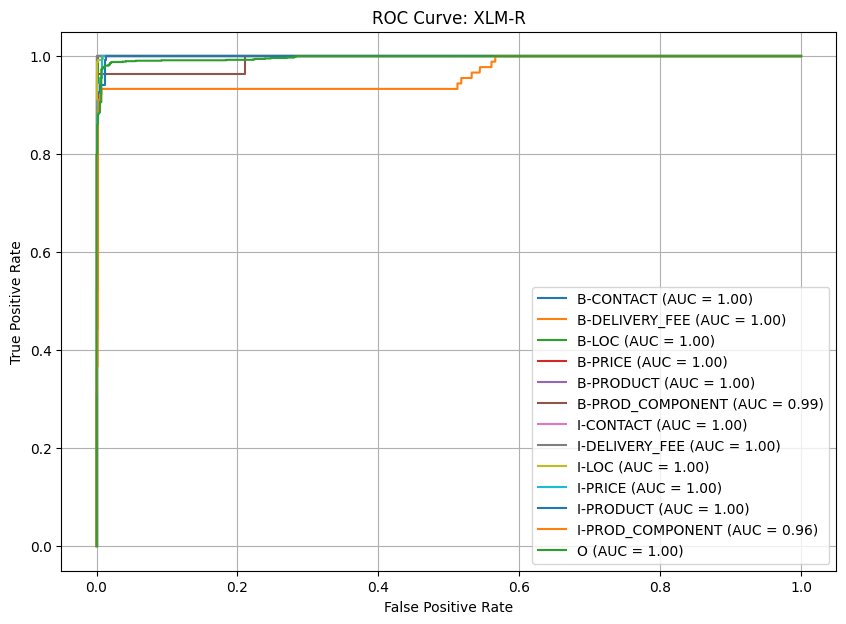

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/tmp/ipykernel_35/2865979825.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer,data_collator=DataCollatorForTokenClassification(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📊 ROC curves for mBERT


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


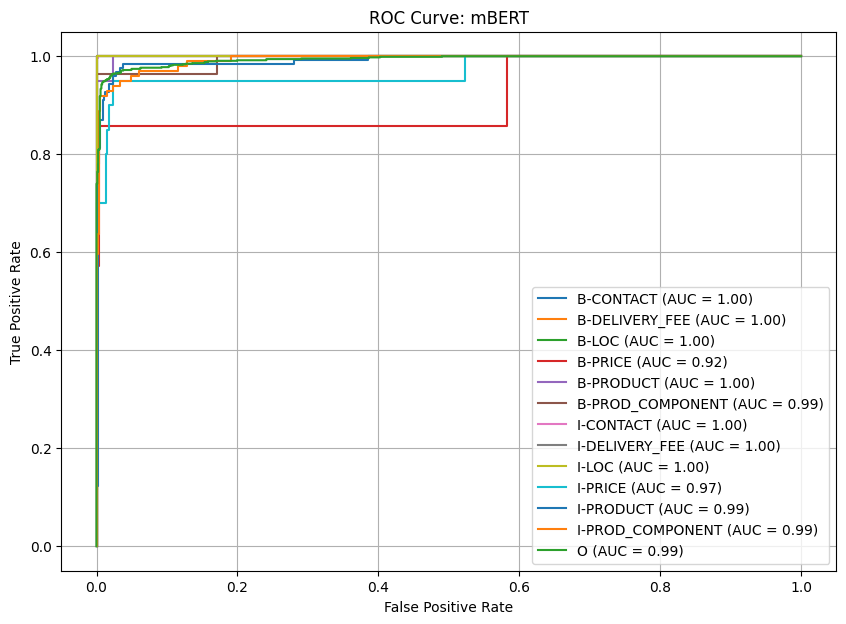

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

/tmp/ipykernel_35/2865979825.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer,data_collator=DataCollatorForTokenClassification(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


📊 ROC curves for DistilBERT


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


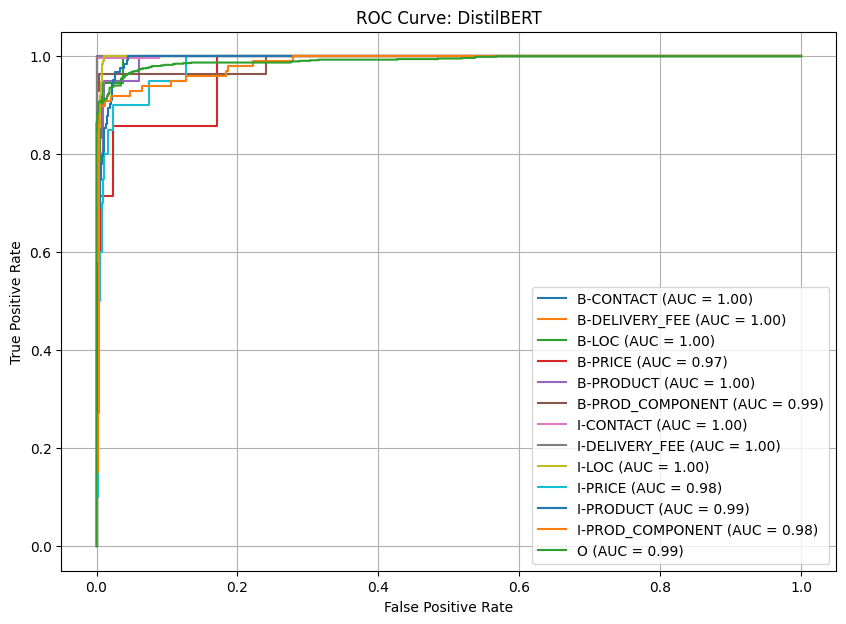

In [ ]:
# plot ROC curves for each model
for name, obj in models.items():
    tokenized_dataset = raw_dataset.map(
        lambda x: tokenize_and_align_labels(x, obj["tokenizer"], label2id),
        batched=True,
    )
    print(f"📊 ROC curves for {name}")
    plot_multiclass_roc(name, obj["model"], obj["tokenizer"], tokenized_dataset["test"], label2id)


# 📈 ROC-AUC Analysis by Entity Type

This section compares model performance across key named entity tags using Area Under the ROC Curve (AUC) scores. These values reflect each model's ability to distinguish a given tag from others—higher AUC means better separability and more confident predictions.

---

## 🧠 Tags Considered
- **LOC** (location)
- **PRICE**
- **PRODUCT**
- **CONTACT**
- **PROD_COMPONENT**
- **DELIVERY FEE**

---

## 🔍 Model-wise Breakdown

### ✅ XLM-RoBERTa
- Achieved **perfect AUC (1.00)** on nearly all tags.
- Slight dips observed for:
  - `B-PROD_COMPONENT`: **0.99**
  - `I-PROD_COMPONENT`: **0.96**
- **Notable Strength**: Maintains extremely high confidence across both outer (`B-`) and inner (`I-`) tokens.

### ✅ mBERT
- Very competitive with high AUCs overall.
- Minor drops in:
  - `B-PRICE`: **0.92**
  - `I-PRICE`: **0.97**
  - `I-PROD_COMPONENT`, `O`: **0.999**
- **Interpretation**: Performs solidly but slightly trails XLM-RoBERTa in detecting nuanced price and component entities.

### ✅ DistilBERT
- Consistently strong, but with:
  - More **variance across tag scores**
  - Slightly **lower AUCs** for complex entity tags like:
    - `I-PROD_COMPONENT`: **0.98**
    - `B-PRICE`: **0.97**
    - `I-PRICE`: **0.98**
- **Best at**: Fast inference with competent but less refined entity separability.

---

## 📊 Summary Table

| Entity Tag        | XLM-R AUC | mBERT AUC | DistilBERT AUC |
|-------------------|-----------|-----------|----------------|
| B-LOC             | 1.00      | 1.00      | 1.00           |
| I-LOC             | 1.00      | 1.00      | 1.00           |
| B-CONTACT         | 1.00      | 1.00      | 1.00           |
| I-CONTACT         | 1.00      | 1.00      | 1.00           |
| B-PRICE           | 1.00      | 0.92      | 0.97           |
| I-PRICE           | 1.00      | 0.97      | 0.98           |
| B-PRODUCT         | 1.00      | 1.00      | 1.00           |
| I-PRODUCT         | 1.00      | 1.00      | 0.99           |
| B-PROD_COMPONENT  | 0.99      | 1.00      | 0.99           |
| I-PROD_COMPONENT  | 0.96      | 0.999     | 0.98           |
| B-DELIVERY_FEE    | 1.00      | 1.00      | 1.00           |
| I-DELIVERY_FEE    | 1.00      | 1.00      | 1.00           |
| O (non-entity)    | 1.00      | 0.999     | 0.99           |

---

## 🏁 Final Thoughts

- **XLM-RoBERTa** exhibits top-tier discriminative power across nearly all tags.
- **mBERT** is close behind with slightly weaker separation in complex spans like `PRICE` and `PROD_COMPONENT`.
- **DistilBERT**, while lightweight and fast, shows more variability—but still delivers solid AUCs.

For business-critical applications where precision at the tag level matters, **XLM-RoBERTa stands out as the most stable choice**.

---

# 📊 Model Comparison and Interpretation – Notebook Summary

This notebook presents a comprehensive workflow for training, evaluating, and comparing three multilingual transformer models for Named Entity Recognition (NER) on Amharic e-commerce data:

- **XLM-RoBERTa**
- **mBERT**
- **DistilBERT**

---

## Workflow Overview

1. **Data Preparation**
    - Loads and parses a CoNLL-formatted dataset to extract tokens and BIO NER tags.
    - Converts the data into a Hugging Face `DatasetDict` with train, validation, and test splits.
    - Maps NER tags to integer IDs for model compatibility.

2. **Model Training**
    - Iterates over three model checkpoints, fine-tuning each model on the training data.
    - Stores evaluation metrics and trained model/tokenizer objects for each model.

3. **Evaluation and Comparison**
    - Collects and displays metrics such as F1 score, accuracy, precision, recall, evaluation loss, and runtime for each model.
    - Ranks models based on key metrics (F1, speed, accuracy).
    - Provides recommendations for model selection based on performance and use-case needs.

4. **Inference on Unseen Data**
    - Runs each fine-tuned model on real-world Amharic product texts.
    - Compares entity extraction quality and robustness across models.

5. **Visualization and Interpretation**
    - Plots parameter distributions, confusion matrices, and ROC curves for all models.
    - Analyzes confusion matrices to understand common misclassifications and tag boundary clarity.
    - Examines ROC-AUC scores for each entity tag to assess discriminative power.

---

## Key Findings

- **XLM-RoBERTa** consistently delivers the highest F1 score, accuracy, and entity boundary precision, making it the best choice for production scenarios where accuracy is critical.
- **mBERT** offers balanced performance with strong generalization and efficiency, serving as a robust alternative.
- **DistilBERT** is the fastest and most lightweight, suitable for resource-constrained or real-time applications, but with some trade-off in accuracy and complex entity detection.

---

## Recommendations

- Use **XLM-RoBERTa** for applications demanding maximum accuracy and robust NER output.
- Consider **mBERT** for balanced performance and efficiency.
- Choose **DistilBERT** when inference speed and model size are top priorities.

---

## Modularization

- **Data loading, tokenization, and metrics** are handled by utility functions in `src/utils/ner_utils.py`.
- **Model loading, saving, and inference pipeline** are modularized in `src/models/ner_model.py`.
- **Training and plotting functions** are organized in the `src/core/` directory for workflow clarity and reusability.

---

**This notebook provides a reproducible, modular, and interpretable template for multilingual NER model comparison and selection using Hugging Face Transformers.**